## **0. Setup**

In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# my_pal = ['grey', 'mediumseagreen']
my_pal = ['grey', 'mediumseagreen', 'dodgerblue', 'darkviolet']

# Make a folder if it not there yet and if needed
# !mkdir ../jupyter_figures

# set the directory where the data files are waiting
directory = '/Users/ShokenLEE/Desktop/DATA/2022 7-9/z'

In [35]:
micron_per_pixel = 0.23

## **1. Concanatate all the CSV files**

In [2]:
df = pd.DataFrame() # for nuclear protein and DAPI intensity data
df_LD = pd.DataFrame() # for LD data

for path, subdirs, files in os.walk(directory):
    for file in files:
        if (file.endswith('csv')) & ('ROI' not in file):
            _df = pd.read_csv(os.path.join(path, file))
            df = pd.concat([df, _df], axis=0)
        elif (file.endswith('csv')) & ('ROI' in file):
            _df = pd.read_csv(os.path.join(path, file))
            df_LD = pd.concat([df_LD, _df], axis=0)

In [3]:
# rename columns
df = df.rename(columns={' ': 'ROI_number'})
df_LD = df_LD[[' ', 'Area', 'File name', 'ROI_number']]

In [4]:
df.info()
# df_LD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 7
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ROI_number  444 non-null    int64  
 1   Area        444 non-null    float64
 2   Mean        444 non-null    float64
 3   Circ.       444 non-null    float64
 4   AR          444 non-null    float64
 5   Round       444 non-null    float64
 6   Solidity    444 non-null    float64
 7   DAPI mean   444 non-null    float64
 8   File name   444 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 34.7+ KB


#### Check the number of files

In [5]:
print(len(df['File name'].unique()), len(df_LD['File name'].unique()))

36 36


## **2. Summerize LD data**

In [9]:
# total area and number (count) of LD per nucleus
df_LD_sumArea = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].sum().rename(columns={'Area': 'total_nLD_area'})
df_LD_count = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].count().rename(columns={'Area': 'number_of_nLD'})

# Merged the two above to summarize LD data
df_LD_summary = df_LD_count.merge(df_LD_sumArea, on=['File name', 'ROI_number'])

# Merge the LD data above to the df of nuclear protein and DAPI intensity data
df = df.merge(df_LD_summary, how='outer', on=['File name', 'ROI_number'])

# fill NA with 0
df.fillna(0, inplace=True)

In [41]:
df['nLD_area_fraction'] = df.total_nLD_area / df.Area

## **3. Group cell/condition types**

In [42]:
df.loc[df['File name'].str.contains('Sctrl'), 'Cell type'] = 'Control'

#### **siRNA type**

In [7]:
# df.loc[df['File name'].str.contains('Sctrl'), 'siRNA type'] = 'None'
df.loc[df['File name'].str.contains('siCtrl'), 'siRNA type'] = 'siCtrl'
df.loc[df['File name'].str.contains('siSun2'), 'siRNA type'] = 'siSun2'
df.loc[df['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = 'siCTDNEP1'

#### **Image number**

In [11]:
df['Image number'] = df['File name'].str[-7:-4]

##### Check the number is correctly extracted

In [12]:
print(list(df['Image number'].unique())[1])

007


## **4. Analysis**

### **Sample size**

In [8]:
df.groupby(['siRNA type']).size()

siRNA type
siCTDNEP1    116
siCtrl       177
siSun2       151
dtype: int64

In [10]:
df[df.number_of_nLD>0].groupby(['siRNA type']).size()

siRNA type
siCTDNEP1    50
siCtrl       75
siSun2       69
dtype: int64

### **Nuclear LD analysis**

### % of cells with nLD

In [45]:
_df_1 = df.groupby(['siRNA type'], as_index=False).size().rename(columns={'size': 'number_of_cells'})
_df_2 = df[df.number_of_nLD > 0].groupby(['siRNA type'], as_index=False).size().rename(columns={'size': 'number_of_cells_w_nLD'})
df_n_cells = _df_1.merge(_df_2, on='siRNA type')

df_n_cells['% of cells with nLD'] = df_n_cells.number_of_cells_w_nLD / df_n_cells.number_of_cells * 100
df_n_cells

,siRNA type,number_of_cells,number_of_cells_w_nLD,% of cells with nLD
0,None,105,28,26.666667


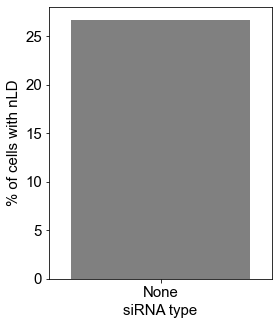

In [46]:
fig = plt.figure(figsize=(4,5))
ax = sns.barplot(data= df_n_cells, x='siRNA type', y='% of cells with nLD',
                palette=my_pal)

In [47]:
fig.savefig(directory + '/%cells_w_nLD.pdf', bbox_inches='tight', transparent=True)

### nLD area: mean values

In [26]:
df.groupby('siRNA type')['nLD_area_fraction'].mean()

siRNA type
siCTDNEP1    0.003202
siCtrl       0.003255
siSun2       0.004576
Name: nLD_area_fraction, dtype: float64

### Mean area of nLD per cell

Text(0, 0.5, 'Area (square micron)')

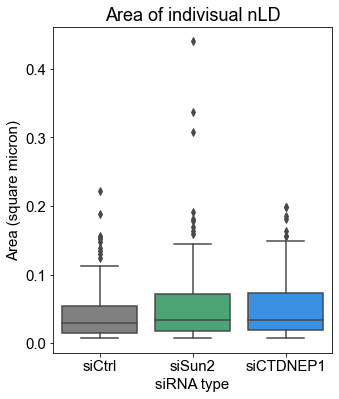

In [52]:
# group siRNA type
df_LD.loc[df_LD['File name'].str.contains('siCtrl'), 'siRNA type'] = 'siCtrl'
df_LD.loc[df_LD['File name'].str.contains('siSun2'), 'siRNA type'] = 'siSun2'
df_LD.loc[df_LD['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = 'siCTDNEP1'

# convert pixel sq to micron sq
df_LD['Area_micronsq'] = df_LD.Area * np.square(0.23)

fig = plt.figure(figsize=(5,6))
ax1 = sns.boxplot(data=df_LD, x='siRNA type', y='Area_micronsq', 
                  order=['siCtrl', 'siSun2', 'siCTDNEP1'], palette=my_pal)
plt.title('Area of indivisual nLD')
plt.ylabel('Area (square micron)')

In [53]:
fig.savefig(directory + '/Area_individual_nLD.pdf', bbox_inches='tight', transparent=True)

### Graphs of nLD area and number

Text(0, 0.5, 'Count')

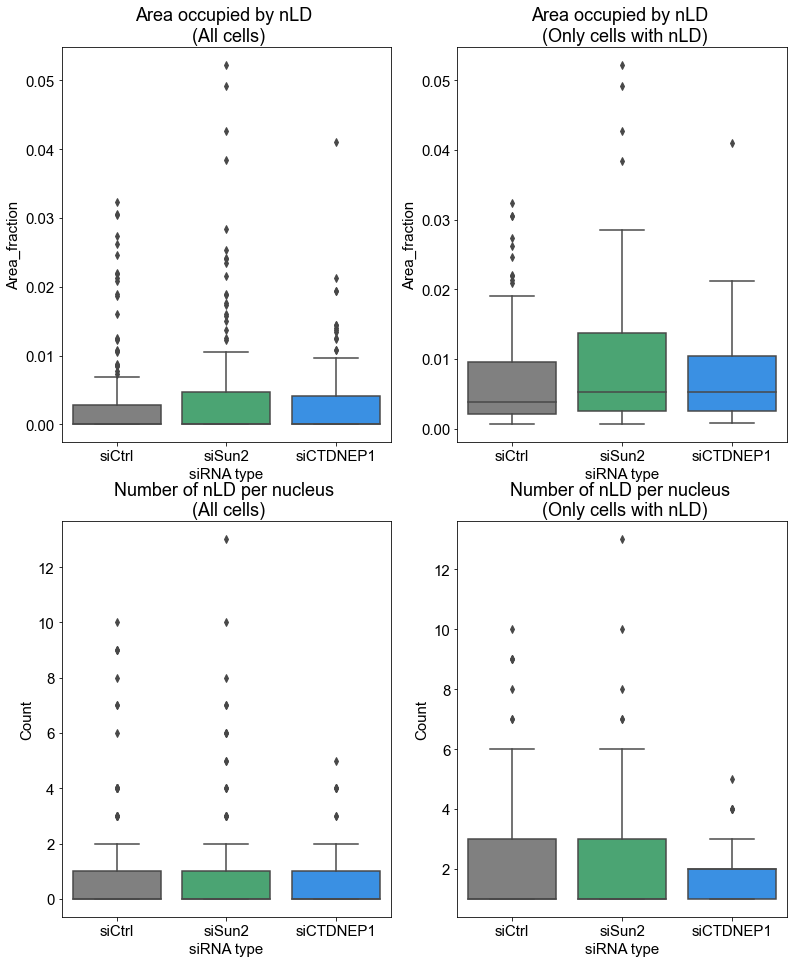

In [59]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig = plt.figure(figsize=(13,16))
ax1 = fig.add_subplot(2,2,1)
# ax1 = sns.xxx

# ax_box = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax1 = sns.boxplot(data=df, x='siRNA type', y='nLD_area_fraction', order=['siCtrl', 'siSun2', 'siCTDNEP1'], palette=my_pal)
plt.title('Area occupied by nLD \n (All cells)')
plt.ylabel('Area_fraction')
# plt.yscale('log')
# ax1.spines['bottom'].set_visible(False)
# ax_box.spines['right'].set_visible(False)

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.boxplot(data=df[df.number_of_nLD > 0], x='siRNA type', y='nLD_area_fraction', order=['siCtrl', 'siSun2', 'siCTDNEP1'], palette=my_pal)
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Area_fraction')

ax3 = fig.add_subplot(2,2,3)
ax3 = sns.boxplot(data=df, x='siRNA type', y='number_of_nLD', order=['siCtrl', 'siSun2', 'siCTDNEP1'], palette=my_pal)
plt.title('Number of nLD per nucleus \n (All cells)')
plt.ylabel('Count')
# plt.yscale('log')

ax3 = fig.add_subplot(2,2,4)
ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x='siRNA type', y='number_of_nLD', order=['siCtrl', 'siSun2', 'siCTDNEP1'], palette=my_pal)
plt.title('Number of nLD per nucleus \n (Only cells with nLD)')
plt.ylabel('Count')
# plt.yscale('log')

In [60]:
fig.savefig(directory + '/nLD_area_number.pdf', bbox_inches='tight', transparent=True)

### **Tukey test**

### With non-nLD cells

In [21]:
res = pairwise_tukeyhsd(df['nLD_area_fraction'], df['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl   0.0001    0.9  -0.002 0.0021  False
siCTDNEP1 siSun2   0.0014 0.2945 -0.0008 0.0035  False
   siCtrl siSun2   0.0013 0.2462 -0.0006 0.0033  False
------------------------------------------------------


### Without non-nLD cells

In [20]:
_df = df[df['number_of_nLD'] > 0]
res = pairwise_tukeyhsd(_df['nLD_area_fraction'], _df['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl   0.0003    0.9 -0.0038 0.0043  False
siCTDNEP1 siSun2   0.0026 0.2955 -0.0015 0.0067  False
   siCtrl siSun2   0.0023  0.293 -0.0013  0.006  False
------------------------------------------------------


#### **C3 channel intensity (background subtracted)**

##### **C3 distribution**

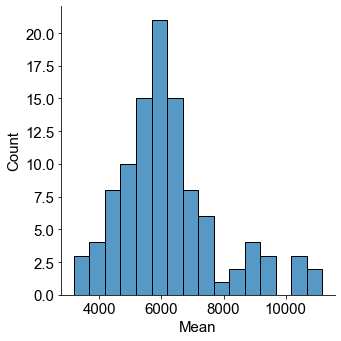

In [48]:
hist = sns.displot(x='Mean', data=df, binwidth=500)
# hist = sns.displot(x='Mean', data=df, col='Cell type', hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal, binwidth=500)

In [49]:
# df.groupby('Tag expression')['Mean'].min()
df['Mean'].min()

3180.545

##### **Background subtraction from C3 intensity value**

In [50]:
background_C3 = 1800

df['C3 mean - background'] = df['Mean'] - background_C3

#### **Scatter plot (nLD area vs Sun2 intensity)**

<Figure size 360x360 with 0 Axes>

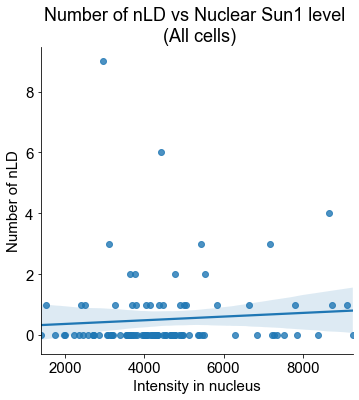

In [54]:
fig = plt.figure(figsize=(5, 5))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df, legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

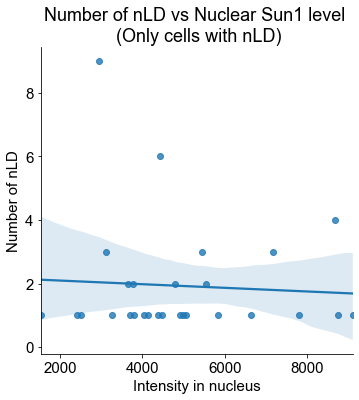

In [53]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

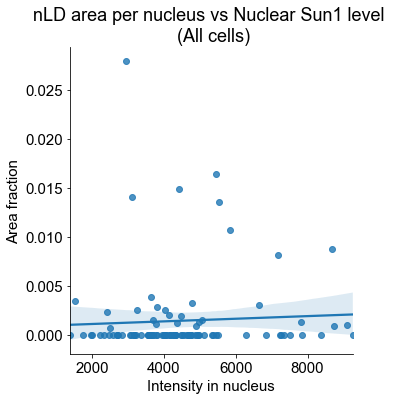

In [55]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df, legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun1_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

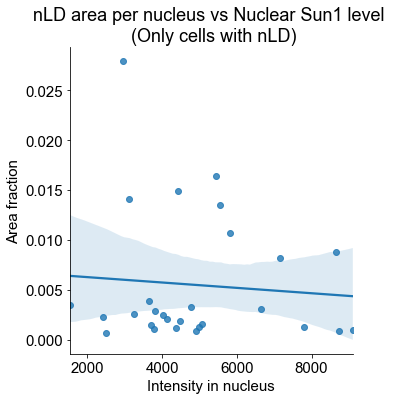

In [56]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

In [98]:
fig.savefig(directory + '/N_of_LD_vs_Sun2_nLD_cells.pdf', transparent=True, bbox_inches='tight')

#### **3-1. Mitotic cells**

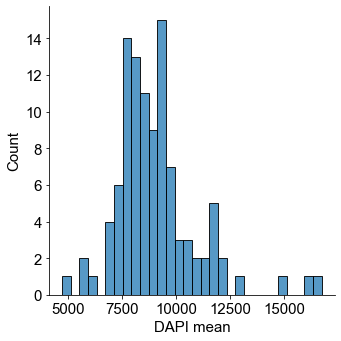

In [14]:
# hist = sns.displot(data=df, x='DAPI mean', hue='Cell type', hue_order=['Control', 'CTDNEP1 KO'], binwidth=400)
hist = sns.displot(data=df, x='DAPI mean', binwidth=400)
# plt.xlim([1000,4000])

#### **Remove cells with too hight DAPI intensity, which are likely mitotic cells**

In [32]:
max_DNA_intensity = 12000

df = df[df['DAPI mean'] < max_DNA_intensity]